# Breast Cancer Detection Model


In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from pathlib import Path
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers, models, Model, optimizers
import cv2
import numpy as np
import pandas as pd
from PIL.Image import open as imread
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold


In [ ]:
# Upload you kaggle key
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ppremdas3","key":"44fee5379d6224c256506466c2bf6158"}'}

In [ ]:
!pip install -q kaggle
!mkdir /root/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Download the kaggle breast cancer dataset
!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset

100% 4.95G/4.95G [00:53<00:00, 191MB/s]
100% 4.95G/4.95G [00:53<00:00, 99.8MB/s]


In [ ]:
!mkdir ddsm
!unzip cbis-ddsm-breast-cancer-image-dataset.zip -d /content/ddsm

Streaming output truncated to the last 5000 lines.
  inflating: /content/ddsm/jpeg/1.3.6.1.4.1.9590.100.1.2.295326067813319071803507885093865003464/1-076.jpg  
  inflating: /content/ddsm/jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/1-265.jpg  
  inflating: /content/ddsm/jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/2-266.jpg  
  inflating: /content/ddsm/jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg  
  inflating: /content/ddsm/jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg  
  inflating: /content/ddsm/jpeg/1.3.6.1.4.1.9590.100.1.2.295397487412067903910787953980192002590/1-233.jpg  
  inflating: /content/ddsm/jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/1-294.jpg  
  inflating: /content/ddsm/jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/2-223.jpg  
  inflating: /content/ddsm/jpeg/1.3.6.1.4.1.9590.100.1.2.29543897441106327461

In [ ]:
cd /content/ddsm

/content/ddsm


In [ ]:
# specify the paths to dicom.csv and to the jpeg DIRECTORY
# take into consideration im using current directory as: /content/ddsm
dicom_path = './csv/dicom_info.csv'
jpeg_path = './jpeg'

In [ ]:
# read the dicom_info csv file
dcm = pd.read_csv(dicom_path)

In [ ]:
# find all types of images
print(set(dcm.SeriesDescription))

{nan, 'ROI mask images', 'cropped images', 'full mammogram images'}


In [ ]:
# edit the paths to set the parent directory properly
dcm.image_path = dcm.image_path.apply(lambda x: x.replace('CBIS-DDSM/jpeg', jpeg_path))

### Explore the data a little bit

In [ ]:
# find all FULL images
full_imgs = dcm[dcm.SeriesDescription=='full mammogram images'].image_path
# find all CROPPED imaged
cropped_imgs = dcm[dcm.SeriesDescription=='cropped images'].image_path
# find all ROI images
roi_imgs = dcm[dcm.SeriesDescription=='ROI mask images'].image_path

Found 3567 cropped images || 2857 full images || and 3247 masks


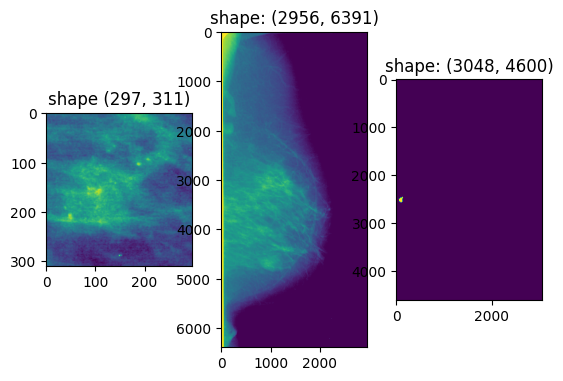

In [ ]:
print(f'Found {len(cropped_imgs)} cropped images || {len(full_imgs)} full images || and {len(roi_imgs)} masks')

index = 42

plt.subplot(1,3,1)
crop = imread(cropped_imgs.iloc[index])
plt.imshow(crop)
plt.title(f'shape {crop.size}')

plt.subplot(1,3,2)
full = imread(full_imgs.iloc[index])
plt.imshow(full)
plt.title(f'shape: {full.size}')

plt.subplot(1,3,3)
mask = imread(roi_imgs.iloc[index])
plt.imshow(mask)
plt.title(f'shape: {mask.size}')

plt.show()

### Now read in the rest of the data

In [ ]:
mass_train_data = pd.read_csv(Path(dicom_path).parent.joinpath('mass_case_description_train_set.csv'))
mass_test_data = pd.read_csv(Path(dicom_path).parent.joinpath('mass_case_description_test_set.csv'))

calc_train_data = pd.read_csv(Path(dicom_path).parent.joinpath('calc_case_description_train_set.csv'))
calc_test_data = pd.read_csv(Path(dicom_path).parent.joinpath('calc_case_description_test_set.csv'))

In [ ]:
mass_train_data.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


_______________________________________________________________________________________________
#### So we have two sets of images, Calcification images and Mass images, each split into Test and Train sets.
#### For this project we use the classification images to find the following:
1) Pathology: Benign or Malignant <br>
_______________________________________________________________________________________________

# Data extraction starts here

In [ ]:
# extract mass cropped train images
mass_cropped_train = []
for i, (_, row) in enumerate(mass_train_data.iterrows()):
    # extract the patient ID from the given path
    bad_path = Path(row['cropped image file path'])
    pid = bad_path.parts[0]
    # now look for the image path in the dcm csv
    patient_data = dcm[dcm['PatientID']==pid]
    cropped_row = patient_data[
        patient_data['SeriesDescription']=='cropped images']
    img_path = cropped_row['image_path'].values[0]

    # if we actually have a path, append it along with its label
    if len(img_path) > 0:
        mass_cropped_train.append([img_path, row['pathology']])



# extract mass cropped test images
mass_cropped_test = []
for i, (_, row) in enumerate(mass_test_data.iterrows()):
    # extract the patient ID from the given path
    bad_path = Path(row['cropped image file path'])
    pid = bad_path.parts[0]
    # now look for the image path in the dcm csv
    patient_data = dcm[dcm['PatientID']==pid]
    cropped_row = patient_data[
        patient_data['SeriesDescription']=='cropped images']
    img_path = cropped_row['image_path'].values[0]

    # if we actually have a path, append it along with its label
    if len(img_path) > 0:
        mass_cropped_test.append([img_path, row['pathology']])



In [ ]:
# extract CALC cropped train images
calc_cropped_train = []
for i, (_, row) in enumerate(calc_train_data.iterrows()):
    # extract the patient ID from the given path
    bad_path = Path(row['cropped image file path'])
    pid = bad_path.parts[0]
    # now look for the image path in the dcm csv
    patient_data = dcm[dcm['PatientID']==pid]
    cropped_row = patient_data[
        patient_data['SeriesDescription']=='cropped images']
    if len(cropped_row)>0:
        img_path = cropped_row['image_path'].values[0]

        # if we actually have a path, append it along with its label
        if len(img_path) > 0:
            calc_cropped_train.append([img_path, row['pathology']])



# extract CALC cropped test images
calc_cropped_test = []
for i, (_, row) in enumerate(calc_test_data.iterrows()):
    # extract the patient ID from the given path
    bad_path = Path(row['cropped image file path'])
    pid = bad_path.parts[0]
    # now look for the image path in the dcm csv
    patient_data = dcm[dcm['PatientID']==pid]
    cropped_row = patient_data[
        patient_data['SeriesDescription']=='cropped images']
    img_path = cropped_row['image_path'].values[0]

    # if we actually have a path, append it along with its label
    if len(img_path) > 0:
        calc_cropped_test.append([img_path, row['pathology']])



In [ ]:
# split X and y for MASS
mass_cropped_X_train = np.array(mass_cropped_train)[:,0]
mass_cropped_y_train = np.array(mass_cropped_train)[:,1]

mass_cropped_X_test = np.array(mass_cropped_test)[:,0]
mass_cropped_y_test = np.array(mass_cropped_test)[:,1]

In [ ]:
# split X and y for CALC
calc_cropped_X_train = np.array(calc_cropped_train)[:,0]
calc_cropped_y_train = np.array(calc_cropped_train)[:,1]

calc_cropped_X_test = np.array(calc_cropped_test)[:,0]
calc_cropped_y_test = np.array(calc_cropped_test)[:,1]

In [ ]:
mass_cropped_X_train

array(['./jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg',
       './jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg',
       './jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/2-295.jpg',
       ...,
       './jpeg/1.3.6.1.4.1.9590.100.1.2.375319587411015946201453923033781478743/1-000.jpg',
       './jpeg/1.3.6.1.4.1.9590.100.1.2.314202752110860447319821482722631603171/1-282.jpg',
       './jpeg/1.3.6.1.4.1.9590.100.1.2.321062807811123845106490625560193258924/1-250.jpg'],
      dtype='<U81')

In [ ]:
# Capture train data and labels into respective lists
SIZE = 256
train_images = []

for img_path in mass_cropped_X_train:
  img = cv2.imread(img_path)
  img = cv2.resize(img, (SIZE, SIZE))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  train_images.append(img)

#Convert lists to arrays
train_images = np.array(train_images)

# Capture train data and labels into respective lists
SIZE = 256
test_images = []

for img_path in mass_cropped_X_test:
  img = cv2.imread(img_path)
  img = cv2.resize(img, (SIZE, SIZE))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  test_images.append(img)

#Convert lists to arrays
test_images = np.array(test_images)

Label Encoding

In [ ]:
for i in range(len(mass_cropped_y_train)):
    if mass_cropped_y_train[i] == 'BENIGN_WITHOUT_CALLBACK':
        mass_cropped_y_train[i] = 'BENIGN'

for i in range(len(mass_cropped_y_test)):
    if mass_cropped_y_test[i] == 'BENIGN_WITHOUT_CALLBACK':
        mass_cropped_y_test[i] = 'BENIGN'

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['MALIGNANT', 'BENIGN'])
mass_cropped_y_train_encoded = le.transform(mass_cropped_y_train)
mass_cropped_y_test_encoded = le.transform(mass_cropped_y_test)

# VGG16 feature extractor

In [ ]:
#VGG-16 feature extractor
VGG = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape = (256,256,3))

#This is to make sure that the trainable parameters are 0
for layer in VGG.layers:
	layer.trainable = False

In [ ]:
VGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

# ResNet feature extractor

In [ ]:
from keras.applications import ResNet50
#Resnet feature extractor
resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape = (256,256,3))

#This is to make sure that the trainable parameters are 0
for layer in resnet.layers:
	layer.trainable = False

In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# Train and test

In [ ]:
#features = features_list.reshape(feature_list.shape[0], -1)
#X_train = features
x_train = train_images
y_train = mass_cropped_y_train_encoded
x_test = test_images
y_test = mass_cropped_y_test_encoded


In [ ]:
#tensorboard
%load_ext tensorboard
import tensorflow as tf
import datetime

# Dense classifier

In [ ]:
# Define the K-fold Cross Validator
# used to change number of units in dense layer 1
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
acc_fold = []
loss_fold = []
fold_no = 1
for train, test in kfold.split(x_train, y_train):
  #dense classifier
  x = VGG.output
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(256, activation = 'relu')(x)
  x = layers.Dense(1, activation = 'sigmoid')(x)

  model=Model(inputs = VGG.input, outputs = x)

  learning_rate = 1e-5
  model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = learning_rate), metrics = 'accuracy')

  from keras import callbacks
  callbacks = callbacks.ModelCheckpoint('VGG_dense.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  history = model.fit(x_train[train], y_train[train], epochs = 30, validation_data = [x_train[test], y_train[test]], callbacks = [callbacks, tensorboard_callback] )
  # Generate generalization metrics
  scores = model.evaluate(x_train[test], y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_fold.append(scores[1] * 100)
  loss_fold.append(scores[0])

  # Increase fold number
  fold_no +=1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
33/33 [==============================] - ETA: 0s - loss: 2.0687 - accuracy: 0.5076
Epoch 1: val_accuracy improved from -inf to 0.52273, saving model to VGG_dense.h15


33/33 [==============================] - 38s 763ms/step - loss: 2.0687 - accuracy: 0.5076 - val_loss: 1.1452 - val_accuracy: 0.5227
Epoch 2/30
33/33 [==============================] - ETA: 0s - loss: 1.4421 - accuracy: 0.5550
Epoch 2: val_accuracy did not improve from 0.52273
33/33 [==============================] - 12s 365ms/step - loss: 1.4421 - accuracy: 0.5550 - val_loss: 1.3823 - val_accuracy: 0.5189
Epoch 3/30
33/33 [==============================] - ETA: 0s - loss: 1.3164 - accuracy: 0.5892
Epoch 3: val_accuracy improved from 0.52273 to 0.52652, saving model to VGG_dense.h15


33/33 [==============================] - 16s 492ms/step - loss: 1.3164 - accuracy: 0.5892 - val_loss: 1.4929 - val_accuracy: 0.5265
Epoch 4/30
33/33 [==============================] - ETA: 0s - loss: 1.1405 - accuracy: 0.6214
Epoch 4: val_accuracy improved from 0.52652 to 0.57955, saving model to VGG_dense.h15


33/33 [==============================] - 16s 495ms/step - loss: 1.1405 - accuracy: 0.6214 - val_loss: 1.0425 - val_accuracy: 0.5795
Epoch 5/30
33/33 [==============================] - ETA: 0s - loss: 1.0745 - accuracy: 0.6395
Epoch 5: val_accuracy did not improve from 0.57955
33/33 [==============================] - 14s 432ms/step - loss: 1.0745 - accuracy: 0.6395 - val_loss: 1.0607 - val_accuracy: 0.5720
Epoch 6/30
33/33 [==============================] - ETA: 0s - loss: 0.9016 - accuracy: 0.6632
Epoch 6: val_accuracy did not improve from 0.57955
33/33 [==============================] - 15s 452ms/step - loss: 0.9016 - accuracy: 0.6632 - val_loss: 1.0031 - val_accuracy: 0.5795
Epoch 7/30
33/33 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.6926
Epoch 7: val_accuracy did not improve from 0.57955
33/33 [==============================] - 14s 419ms/step - loss: 0.8296 - accuracy: 0.6926 - val_loss: 1.0159 - val_accuracy: 0.5682
Epoch 8/30
33/33 [===================

33/33 [==============================] - 15s 473ms/step - loss: 0.6559 - accuracy: 0.7334 - val_loss: 1.0884 - val_accuracy: 0.5833
Epoch 11/30
33/33 [==============================] - ETA: 0s - loss: 0.6076 - accuracy: 0.7410
Epoch 11: val_accuracy improved from 0.58333 to 0.59470, saving model to VGG_dense.h15


33/33 [==============================] - 16s 483ms/step - loss: 0.6076 - accuracy: 0.7410 - val_loss: 1.0856 - val_accuracy: 0.5947
Epoch 12/30
33/33 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.7628
Epoch 12: val_accuracy did not improve from 0.59470
33/33 [==============================] - 12s 357ms/step - loss: 0.5900 - accuracy: 0.7628 - val_loss: 1.2732 - val_accuracy: 0.5720
Epoch 13/30
33/33 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.7742
Epoch 13: val_accuracy did not improve from 0.59470
33/33 [==============================] - 13s 395ms/step - loss: 0.5225 - accuracy: 0.7742 - val_loss: 1.1039 - val_accuracy: 0.5871
Epoch 14/30
33/33 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.7875
Epoch 14: val_accuracy did not improve from 0.59470
33/33 [==============================] - 12s 379ms/step - loss: 0.4900 - accuracy: 0.7875 - val_loss: 1.1101 - val_accuracy: 0.5758
Epoch 15/30
33/33 [============

33/33 [==============================] - 16s 502ms/step - loss: 0.4057 - accuracy: 0.8273 - val_loss: 1.0178 - val_accuracy: 0.5985
Epoch 20/30
33/33 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.8368
Epoch 20: val_accuracy did not improve from 0.59848
33/33 [==============================] - 13s 386ms/step - loss: 0.3868 - accuracy: 0.8368 - val_loss: 0.9805 - val_accuracy: 0.5947
Epoch 21/30
33/33 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.8197
Epoch 21: val_accuracy improved from 0.59848 to 0.60227, saving model to VGG_dense.h15


33/33 [==============================] - 15s 476ms/step - loss: 0.3836 - accuracy: 0.8197 - val_loss: 1.1483 - val_accuracy: 0.6023
Epoch 22/30
33/33 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8596
Epoch 22: val_accuracy did not improve from 0.60227
33/33 [==============================] - 13s 402ms/step - loss: 0.3459 - accuracy: 0.8596 - val_loss: 1.1181 - val_accuracy: 0.5871
Epoch 23/30
33/33 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.8520
Epoch 23: val_accuracy did not improve from 0.60227
33/33 [==============================] - 13s 399ms/step - loss: 0.3282 - accuracy: 0.8520 - val_loss: 1.0232 - val_accuracy: 0.6023
Epoch 24/30
33/33 [==============================] - ETA: 0s - loss: 0.3004 - accuracy: 0.8700
Epoch 24: val_accuracy did not improve from 0.60227
33/33 [==============================] - 13s 400ms/step - loss: 0.3004 - accuracy: 0.8700 - val_loss: 1.1686 - val_accuracy: 0.5795
Epoch 25/30
33/33 [============

33/33 [==============================] - 16s 487ms/step - loss: 0.3012 - accuracy: 0.8852 - val_loss: 1.0497 - val_accuracy: 0.6061
Epoch 27/30
33/33 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.8814
Epoch 27: val_accuracy did not improve from 0.60606
33/33 [==============================] - 12s 362ms/step - loss: 0.2727 - accuracy: 0.8814 - val_loss: 1.0346 - val_accuracy: 0.5985
Epoch 28/30
33/33 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.8918
Epoch 28: val_accuracy did not improve from 0.60606
33/33 [==============================] - 13s 401ms/step - loss: 0.2591 - accuracy: 0.8918 - val_loss: 1.1300 - val_accuracy: 0.5909
Epoch 29/30
33/33 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.8937
Epoch 29: val_accuracy improved from 0.60606 to 0.62121, saving model to VGG_dense.h15


33/33 [==============================] - 15s 473ms/step - loss: 0.2368 - accuracy: 0.8937 - val_loss: 0.9610 - val_accuracy: 0.6212
Epoch 30/30
33/33 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.8672
Epoch 30: val_accuracy did not improve from 0.62121
33/33 [==============================] - 12s 360ms/step - loss: 0.2869 - accuracy: 0.8672 - val_loss: 1.1352 - val_accuracy: 0.5909
Score for fold 1: loss of 1.1351960897445679; accuracy of 59.090906381607056%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/30
33/33 [==============================] - ETA: 0s - loss: 1.8481 - accuracy: 0.5323
Epoch 1: val_accuracy improved from -inf to 0.49242, saving model to VGG_dense.h15


33/33 [==============================] - 17s 499ms/step - loss: 1.8481 - accuracy: 0.5323 - val_loss: 1.3703 - val_accuracy: 0.4924
Epoch 2/30
33/33 [==============================] - ETA: 0s - loss: 1.4418 - accuracy: 0.6015
Epoch 2: val_accuracy improved from 0.49242 to 0.49621, saving model to VGG_dense.h15


33/33 [==============================] - 14s 442ms/step - loss: 1.4418 - accuracy: 0.6015 - val_loss: 1.3606 - val_accuracy: 0.4962
Epoch 3/30
33/33 [==============================] - ETA: 0s - loss: 1.2928 - accuracy: 0.5939
Epoch 3: val_accuracy improved from 0.49621 to 0.51515, saving model to VGG_dense.h15


33/33 [==============================] - 15s 469ms/step - loss: 1.2928 - accuracy: 0.5939 - val_loss: 1.2725 - val_accuracy: 0.5152
Epoch 4/30
33/33 [==============================] - ETA: 0s - loss: 1.0835 - accuracy: 0.6309
Epoch 4: val_accuracy improved from 0.51515 to 0.54167, saving model to VGG_dense.h15


33/33 [==============================] - 14s 440ms/step - loss: 1.0835 - accuracy: 0.6309 - val_loss: 1.2087 - val_accuracy: 0.5417
Epoch 5/30
33/33 [==============================] - ETA: 0s - loss: 1.0616 - accuracy: 0.6338
Epoch 5: val_accuracy improved from 0.54167 to 0.54545, saving model to VGG_dense.h15


33/33 [==============================] - 15s 470ms/step - loss: 1.0616 - accuracy: 0.6338 - val_loss: 1.2074 - val_accuracy: 0.5455
Epoch 6/30
33/33 [==============================] - ETA: 0s - loss: 0.9101 - accuracy: 0.6632
Epoch 6: val_accuracy improved from 0.54545 to 0.55682, saving model to VGG_dense.h15


33/33 [==============================] - 15s 451ms/step - loss: 0.9101 - accuracy: 0.6632 - val_loss: 1.1603 - val_accuracy: 0.5568
Epoch 7/30
33/33 [==============================] - ETA: 0s - loss: 0.8111 - accuracy: 0.6983
Epoch 7: val_accuracy did not improve from 0.55682
33/33 [==============================] - 12s 360ms/step - loss: 0.8111 - accuracy: 0.6983 - val_loss: 1.1731 - val_accuracy: 0.5455
Epoch 8/30
33/33 [==============================] - ETA: 0s - loss: 0.8267 - accuracy: 0.6973
Epoch 8: val_accuracy did not improve from 0.55682
33/33 [==============================] - 13s 397ms/step - loss: 0.8267 - accuracy: 0.6973 - val_loss: 1.1346 - val_accuracy: 0.5530
Epoch 9/30
33/33 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.7306
Epoch 9: val_accuracy did not improve from 0.55682
33/33 [==============================] - 12s 362ms/step - loss: 0.7158 - accuracy: 0.7306 - val_loss: 1.1566 - val_accuracy: 0.5530
Epoch 10/30
33/33 [==================

33/33 [==============================] - 14s 434ms/step - loss: 0.6758 - accuracy: 0.7486 - val_loss: 1.1144 - val_accuracy: 0.5682
Epoch 11/30
33/33 [==============================] - ETA: 0s - loss: 0.6210 - accuracy: 0.7628
Epoch 11: val_accuracy did not improve from 0.56818
33/33 [==============================] - 13s 391ms/step - loss: 0.6210 - accuracy: 0.7628 - val_loss: 1.1645 - val_accuracy: 0.5568
Epoch 12/30
33/33 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.7875
Epoch 12: val_accuracy improved from 0.56818 to 0.59848, saving model to VGG_dense.h15


33/33 [==============================] - 14s 435ms/step - loss: 0.5428 - accuracy: 0.7875 - val_loss: 1.0949 - val_accuracy: 0.5985
Epoch 13/30
33/33 [==============================] - ETA: 0s - loss: 0.5921 - accuracy: 0.7694
Epoch 13: val_accuracy did not improve from 0.59848
33/33 [==============================] - 13s 394ms/step - loss: 0.5921 - accuracy: 0.7694 - val_loss: 1.1978 - val_accuracy: 0.5455
Epoch 14/30
33/33 [==============================] - ETA: 0s - loss: 0.4814 - accuracy: 0.8017
Epoch 14: val_accuracy did not improve from 0.59848
33/33 [==============================] - 12s 370ms/step - loss: 0.4814 - accuracy: 0.8017 - val_loss: 1.1663 - val_accuracy: 0.5606
Epoch 15/30
33/33 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.8055
Epoch 15: val_accuracy did not improve from 0.59848
33/33 [==============================] - 13s 386ms/step - loss: 0.4831 - accuracy: 0.8055 - val_loss: 1.1256 - val_accuracy: 0.5720
Epoch 16/30
33/33 [============

33/33 [==============================] - 17s 487ms/step - loss: 1.5915 - accuracy: 0.5218 - val_loss: 0.9605 - val_accuracy: 0.5417
Epoch 2/30
33/33 [==============================] - ETA: 0s - loss: 1.3674 - accuracy: 0.5503
Epoch 2: val_accuracy improved from 0.54167 to 0.60227, saving model to VGG_dense.h15


33/33 [==============================] - 15s 472ms/step - loss: 1.3674 - accuracy: 0.5503 - val_loss: 0.8352 - val_accuracy: 0.6023
Epoch 3/30
33/33 [==============================] - ETA: 0s - loss: 1.1093 - accuracy: 0.6176
Epoch 3: val_accuracy improved from 0.60227 to 0.64015, saving model to VGG_dense.h15


33/33 [==============================] - 15s 473ms/step - loss: 1.1093 - accuracy: 0.6176 - val_loss: 0.8366 - val_accuracy: 0.6402
Epoch 4/30
33/33 [==============================] - ETA: 0s - loss: 0.9771 - accuracy: 0.6442
Epoch 4: val_accuracy improved from 0.64015 to 0.65152, saving model to VGG_dense.h15


33/33 [==============================] - 15s 467ms/step - loss: 0.9771 - accuracy: 0.6442 - val_loss: 0.7276 - val_accuracy: 0.6515
Epoch 5/30
33/33 [==============================] - ETA: 0s - loss: 0.9348 - accuracy: 0.6575
Epoch 5: val_accuracy did not improve from 0.65152
33/33 [==============================] - 12s 359ms/step - loss: 0.9348 - accuracy: 0.6575 - val_loss: 0.7678 - val_accuracy: 0.6515
Epoch 6/30
33/33 [==============================] - ETA: 0s - loss: 0.9093 - accuracy: 0.6670
Epoch 6: val_accuracy improved from 0.65152 to 0.67424, saving model to VGG_dense.h15


33/33 [==============================] - 14s 431ms/step - loss: 0.9093 - accuracy: 0.6670 - val_loss: 0.6778 - val_accuracy: 0.6742
Epoch 7/30
33/33 [==============================] - ETA: 0s - loss: 0.7923 - accuracy: 0.6973
Epoch 7: val_accuracy improved from 0.67424 to 0.69697, saving model to VGG_dense.h15


33/33 [==============================] - 14s 447ms/step - loss: 0.7923 - accuracy: 0.6973 - val_loss: 0.6871 - val_accuracy: 0.6970
Epoch 8/30
33/33 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.7097
Epoch 8: val_accuracy did not improve from 0.69697
33/33 [==============================] - 13s 393ms/step - loss: 0.7352 - accuracy: 0.7097 - val_loss: 0.6434 - val_accuracy: 0.6818
Epoch 9/30
33/33 [==============================] - ETA: 0s - loss: 0.7245 - accuracy: 0.7201
Epoch 9: val_accuracy did not improve from 0.69697
33/33 [==============================] - 13s 395ms/step - loss: 0.7245 - accuracy: 0.7201 - val_loss: 0.6423 - val_accuracy: 0.6894
Epoch 10/30
33/33 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.7495
Epoch 10: val_accuracy did not improve from 0.69697
33/33 [==============================] - 13s 394ms/step - loss: 0.6120 - accuracy: 0.7495 - val_loss: 0.7072 - val_accuracy: 0.6742
Epoch 11/30
33/33 [================

33/33 [==============================] - 21s 650ms/step - loss: 0.5066 - accuracy: 0.7865 - val_loss: 0.6442 - val_accuracy: 0.7045
Epoch 13/30
33/33 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.7732
Epoch 13: val_accuracy did not improve from 0.70455
33/33 [==============================] - 14s 420ms/step - loss: 0.5485 - accuracy: 0.7732 - val_loss: 0.6350 - val_accuracy: 0.6894
Epoch 14/30
33/33 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.7989
Epoch 14: val_accuracy did not improve from 0.70455
33/33 [==============================] - 13s 401ms/step - loss: 0.4864 - accuracy: 0.7989 - val_loss: 0.6336 - val_accuracy: 0.7008
Epoch 15/30
33/33 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.7941
Epoch 15: val_accuracy did not improve from 0.70455
33/33 [==============================] - 12s 365ms/step - loss: 0.4920 - accuracy: 0.7941 - val_loss: 0.6392 - val_accuracy: 0.7008
Epoch 16/30
33/33 [============

33/33 [==============================] - 14s 430ms/step - loss: 0.4177 - accuracy: 0.8121 - val_loss: 0.6485 - val_accuracy: 0.7083
Epoch 18/30
33/33 [==============================] - ETA: 0s - loss: 0.3699 - accuracy: 0.8302
Epoch 18: val_accuracy did not improve from 0.70833
33/33 [==============================] - 13s 391ms/step - loss: 0.3699 - accuracy: 0.8302 - val_loss: 0.6334 - val_accuracy: 0.7008
Epoch 19/30
33/33 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8416
Epoch 19: val_accuracy did not improve from 0.70833
33/33 [==============================] - 13s 395ms/step - loss: 0.3833 - accuracy: 0.8416 - val_loss: 0.6427 - val_accuracy: 0.6932
Epoch 20/30
33/33 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.8558
Epoch 20: val_accuracy did not improve from 0.70833
33/33 [==============================] - 13s 397ms/step - loss: 0.3509 - accuracy: 0.8558 - val_loss: 0.6486 - val_accuracy: 0.7083
Epoch 21/30
33/33 [============

33/33 [==============================] - 15s 458ms/step - loss: 0.3602 - accuracy: 0.8340 - val_loss: 0.6482 - val_accuracy: 0.7197
Epoch 23/30
33/33 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.8833
Epoch 23: val_accuracy did not improve from 0.71970
33/33 [==============================] - 13s 392ms/step - loss: 0.2970 - accuracy: 0.8833 - val_loss: 0.6428 - val_accuracy: 0.7121
Epoch 24/30
33/33 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.8567
Epoch 24: val_accuracy improved from 0.71970 to 0.72348, saving model to VGG_dense.h15


33/33 [==============================] - 14s 440ms/step - loss: 0.3095 - accuracy: 0.8567 - val_loss: 0.6646 - val_accuracy: 0.7235
Epoch 25/30
33/33 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8748
Epoch 25: val_accuracy did not improve from 0.72348
33/33 [==============================] - 12s 363ms/step - loss: 0.2850 - accuracy: 0.8748 - val_loss: 0.6786 - val_accuracy: 0.7083
Epoch 26/30
33/33 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8805
Epoch 26: val_accuracy did not improve from 0.72348
33/33 [==============================] - 13s 402ms/step - loss: 0.2892 - accuracy: 0.8805 - val_loss: 0.6598 - val_accuracy: 0.7197
Epoch 27/30
33/33 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.8880
Epoch 27: val_accuracy did not improve from 0.72348
33/33 [==============================] - 13s 401ms/step - loss: 0.2671 - accuracy: 0.8880 - val_loss: 0.6684 - val_accuracy: 0.6894
Epoch 28/30
33/33 [============

33/33 [==============================] - 25s 748ms/step - loss: 1.7859 - accuracy: 0.5043 - val_loss: 1.0639 - val_accuracy: 0.5475
Epoch 2/30
33/33 [==============================] - ETA: 0s - loss: 1.3838 - accuracy: 0.5498
Epoch 2: val_accuracy improved from 0.54753 to 0.56654, saving model to VGG_dense.h15


33/33 [==============================] - 16s 502ms/step - loss: 1.3838 - accuracy: 0.5498 - val_loss: 0.9602 - val_accuracy: 0.5665
Epoch 3/30
33/33 [==============================] - ETA: 0s - loss: 1.1674 - accuracy: 0.5810
Epoch 3: val_accuracy improved from 0.56654 to 0.58935, saving model to VGG_dense.h15


33/33 [==============================] - 15s 466ms/step - loss: 1.1674 - accuracy: 0.5810 - val_loss: 0.9093 - val_accuracy: 0.5894
Epoch 4/30
33/33 [==============================] - ETA: 0s - loss: 1.0364 - accuracy: 0.6237
Epoch 4: val_accuracy improved from 0.58935 to 0.62357, saving model to VGG_dense.h15


33/33 [==============================] - 15s 467ms/step - loss: 1.0364 - accuracy: 0.6237 - val_loss: 0.8737 - val_accuracy: 0.6236
Epoch 5/30
33/33 [==============================] - ETA: 0s - loss: 0.9594 - accuracy: 0.6445
Epoch 5: val_accuracy improved from 0.62357 to 0.64259, saving model to VGG_dense.h15


33/33 [==============================] - 14s 422ms/step - loss: 0.9594 - accuracy: 0.6445 - val_loss: 0.8604 - val_accuracy: 0.6426
Epoch 6/30
33/33 [==============================] - ETA: 0s - loss: 0.9428 - accuracy: 0.6427
Epoch 6: val_accuracy improved from 0.64259 to 0.65019, saving model to VGG_dense.h15


33/33 [==============================] - 14s 442ms/step - loss: 0.9428 - accuracy: 0.6427 - val_loss: 0.8053 - val_accuracy: 0.6502
Epoch 7/30
33/33 [==============================] - ETA: 0s - loss: 0.8866 - accuracy: 0.6815
Epoch 7: val_accuracy improved from 0.65019 to 0.65779, saving model to VGG_dense.h15


33/33 [==============================] - 15s 476ms/step - loss: 0.8866 - accuracy: 0.6815 - val_loss: 0.7943 - val_accuracy: 0.6578
Epoch 8/30
33/33 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.7052
Epoch 8: val_accuracy improved from 0.65779 to 0.66160, saving model to VGG_dense.h15


33/33 [==============================] - 16s 498ms/step - loss: 0.7436 - accuracy: 0.7052 - val_loss: 0.7782 - val_accuracy: 0.6616
Epoch 9/30
33/33 [==============================] - ETA: 0s - loss: 0.7141 - accuracy: 0.7109
Epoch 9: val_accuracy improved from 0.66160 to 0.67681, saving model to VGG_dense.h15


33/33 [==============================] - 15s 477ms/step - loss: 0.7141 - accuracy: 0.7109 - val_loss: 0.7704 - val_accuracy: 0.6768
Epoch 10/30
33/33 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.7346
Epoch 10: val_accuracy did not improve from 0.67681
33/33 [==============================] - 14s 430ms/step - loss: 0.6545 - accuracy: 0.7346 - val_loss: 0.7754 - val_accuracy: 0.6616
Epoch 11/30
33/33 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.7469
Epoch 11: val_accuracy did not improve from 0.67681
33/33 [==============================] - 12s 384ms/step - loss: 0.6092 - accuracy: 0.7469 - val_loss: 0.7726 - val_accuracy: 0.6730
Epoch 12/30
33/33 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.7526
Epoch 12: val_accuracy improved from 0.67681 to 0.68441, saving model to VGG_dense.h15


33/33 [==============================] - 16s 501ms/step - loss: 0.5989 - accuracy: 0.7526 - val_loss: 0.7536 - val_accuracy: 0.6844
Epoch 13/30
33/33 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.7735
Epoch 13: val_accuracy did not improve from 0.68441
33/33 [==============================] - 13s 394ms/step - loss: 0.5580 - accuracy: 0.7735 - val_loss: 0.7548 - val_accuracy: 0.6768
Epoch 14/30
33/33 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.7649
Epoch 14: val_accuracy improved from 0.68441 to 0.69202, saving model to VGG_dense.h15


33/33 [==============================] - 16s 505ms/step - loss: 0.5259 - accuracy: 0.7649 - val_loss: 0.7371 - val_accuracy: 0.6920
Epoch 15/30
33/33 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.7867
Epoch 15: val_accuracy did not improve from 0.69202
33/33 [==============================] - 13s 395ms/step - loss: 0.5077 - accuracy: 0.7867 - val_loss: 0.7441 - val_accuracy: 0.6882
Epoch 16/30
33/33 [==============================] - ETA: 0s - loss: 0.4573 - accuracy: 0.7943
Epoch 16: val_accuracy improved from 0.69202 to 0.70342, saving model to VGG_dense.h15


33/33 [==============================] - 16s 484ms/step - loss: 0.4573 - accuracy: 0.7943 - val_loss: 0.7284 - val_accuracy: 0.7034
Epoch 17/30
33/33 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.7953
Epoch 17: val_accuracy improved from 0.70342 to 0.71103, saving model to VGG_dense.h15


33/33 [==============================] - 15s 474ms/step - loss: 0.4778 - accuracy: 0.7953 - val_loss: 0.7231 - val_accuracy: 0.7110
Epoch 18/30
33/33 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.7953
Epoch 18: val_accuracy did not improve from 0.71103
33/33 [==============================] - 12s 369ms/step - loss: 0.4491 - accuracy: 0.7953 - val_loss: 0.7248 - val_accuracy: 0.6920
Epoch 19/30
33/33 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8171
Epoch 19: val_accuracy did not improve from 0.71103
33/33 [==============================] - 13s 402ms/step - loss: 0.4132 - accuracy: 0.8171 - val_loss: 0.7363 - val_accuracy: 0.6768
Epoch 20/30
33/33 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.8313
Epoch 20: val_accuracy did not improve from 0.71103
33/33 [==============================] - 13s 400ms/step - loss: 0.3865 - accuracy: 0.8313 - val_loss: 0.7224 - val_accuracy: 0.6958
Epoch 21/30
33/33 [============

33/33 [==============================] - 17s 490ms/step - loss: 1.6651 - accuracy: 0.4929 - val_loss: 1.0905 - val_accuracy: 0.5589
Epoch 2/30
33/33 [==============================] - ETA: 0s - loss: 1.3305 - accuracy: 0.5384
Epoch 2: val_accuracy improved from 0.55894 to 0.58555, saving model to VGG_dense.h15


33/33 [==============================] - 15s 465ms/step - loss: 1.3305 - accuracy: 0.5384 - val_loss: 0.9802 - val_accuracy: 0.5856
Epoch 3/30
33/33 [==============================] - ETA: 0s - loss: 1.1933 - accuracy: 0.5896
Epoch 3: val_accuracy improved from 0.58555 to 0.59316, saving model to VGG_dense.h15


33/33 [==============================] - 15s 461ms/step - loss: 1.1933 - accuracy: 0.5896 - val_loss: 0.9740 - val_accuracy: 0.5932
Epoch 4/30
33/33 [==============================] - ETA: 0s - loss: 0.9829 - accuracy: 0.6427
Epoch 4: val_accuracy improved from 0.59316 to 0.59696, saving model to VGG_dense.h15


33/33 [==============================] - 14s 440ms/step - loss: 0.9829 - accuracy: 0.6427 - val_loss: 0.8896 - val_accuracy: 0.5970
Epoch 5/30
33/33 [==============================] - ETA: 0s - loss: 0.8897 - accuracy: 0.6777
Epoch 5: val_accuracy did not improve from 0.59696
33/33 [==============================] - 12s 364ms/step - loss: 0.8897 - accuracy: 0.6777 - val_loss: 0.8510 - val_accuracy: 0.5779
Epoch 6/30
33/33 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.7005
Epoch 6: val_accuracy improved from 0.59696 to 0.60076, saving model to VGG_dense.h15


33/33 [==============================] - 15s 455ms/step - loss: 0.7563 - accuracy: 0.7005 - val_loss: 0.8314 - val_accuracy: 0.6008
Epoch 7/30
33/33 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.7318
Epoch 7: val_accuracy improved from 0.60076 to 0.61217, saving model to VGG_dense.h15


33/33 [==============================] - 16s 480ms/step - loss: 0.6624 - accuracy: 0.7318 - val_loss: 0.8508 - val_accuracy: 0.6122
Epoch 8/30
33/33 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.6967
Epoch 8: val_accuracy did not improve from 0.61217
33/33 [==============================] - 12s 359ms/step - loss: 0.6825 - accuracy: 0.6967 - val_loss: 0.8590 - val_accuracy: 0.6084
Epoch 9/30
33/33 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.7109
Epoch 9: val_accuracy improved from 0.61217 to 0.61977, saving model to VGG_dense.h15


33/33 [==============================] - 15s 467ms/step - loss: 0.7017 - accuracy: 0.7109 - val_loss: 0.8256 - val_accuracy: 0.6198
Epoch 10/30
33/33 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.7469
Epoch 10: val_accuracy improved from 0.61977 to 0.62357, saving model to VGG_dense.h15


33/33 [==============================] - 14s 434ms/step - loss: 0.6081 - accuracy: 0.7469 - val_loss: 0.8278 - val_accuracy: 0.6236
Epoch 11/30
33/33 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.7431
Epoch 11: val_accuracy improved from 0.62357 to 0.64259, saving model to VGG_dense.h15


33/33 [==============================] - 16s 483ms/step - loss: 0.6061 - accuracy: 0.7431 - val_loss: 0.8290 - val_accuracy: 0.6426
Epoch 12/30
33/33 [==============================] - ETA: 0s - loss: 0.5694 - accuracy: 0.7564
Epoch 12: val_accuracy did not improve from 0.64259
33/33 [==============================] - 12s 362ms/step - loss: 0.5694 - accuracy: 0.7564 - val_loss: 0.8152 - val_accuracy: 0.6274
Epoch 13/30
33/33 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.7754
Epoch 13: val_accuracy did not improve from 0.64259
33/33 [==============================] - 13s 402ms/step - loss: 0.4882 - accuracy: 0.7754 - val_loss: 0.8095 - val_accuracy: 0.6312
Epoch 14/30
33/33 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.7991
Epoch 14: val_accuracy did not improve from 0.64259
33/33 [==============================] - 12s 362ms/step - loss: 0.4714 - accuracy: 0.7991 - val_loss: 0.8382 - val_accuracy: 0.6312
Epoch 15/30
33/33 [============

33/33 [==============================] - 16s 479ms/step - loss: 0.3318 - accuracy: 0.8559 - val_loss: 0.8516 - val_accuracy: 0.6540
Epoch 22/30
33/33 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.8654
Epoch 22: val_accuracy did not improve from 0.65399
33/33 [==============================] - 13s 394ms/step - loss: 0.3044 - accuracy: 0.8654 - val_loss: 0.8443 - val_accuracy: 0.6426
Epoch 23/30
33/33 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.8664
Epoch 23: val_accuracy did not improve from 0.65399
33/33 [==============================] - 13s 397ms/step - loss: 0.2978 - accuracy: 0.8664 - val_loss: 0.8466 - val_accuracy: 0.6502
Epoch 24/30
33/33 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8607
Epoch 24: val_accuracy did not improve from 0.65399
33/33 [==============================] - 13s 397ms/step - loss: 0.3067 - accuracy: 0.8607 - val_loss: 0.8360 - val_accuracy: 0.6388
Epoch 25/30
33/33 [============

In [ ]:
#dense classifier
x = VGG.output
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model=Model(inputs = VGG.input, outputs = x)

learning_rate = 1e-5
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = learning_rate), metrics = 'accuracy')

#callbacks = callbacks.ModelCheckpoint(filepath='VGG_dense64final.h15')
log_dir = "logs/fit2/" + 'final64'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Generate a print
history = model.fit(x_train, y_train, epochs = 30, callbacks = tensorboard_callback)

from sklearn.metrics import accuracy_score
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#Save model for future use
filename = '64dense.sav'
import pickle
pickle.dump(model, open(filename, 'wb'))

In [ ]:
%tensorboard --logdir logs/fit


VGG if we want to fine tune

In [ ]:
num_trainable = 4 #number of layers we want to fine tune
VGG.trainable = True
for layer in VGG.layers[:-num_trainable]: #train last x layers
  layer.trainable=False

VGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
#dense classifier post-finetune
x = VGG.output
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model=Model(inputs = VGG.input, outputs = x)

learning_rate = 1e-5
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = learning_rate), metrics = 'accuracy')

#callbacks = callbacks.ModelCheckpoint(filepath='VGG_dense64final.h15')
log_dir = "logs/fit2/" + 'ftfinal64'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Generate a print
history = model.fit(x_train, y_train, epochs = 30, callbacks = tensorboard_callback)

accuracy = accuracy_score(y_test, np.round(y_pred))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#Save model for future use
filename = 'ft64dense.sav'
pickle.dump(model, open(filename, 'wb'))

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.5570 - accuracy: 0.4962
Epoch 1: val_accuracy improved from -inf to 0.53175, saving model to VGG_tuned_dense.h15


42/42 [==============================] - 28s 580ms/step - loss: 1.5570 - accuracy: 0.4962 - val_loss: 0.8275 - val_accuracy: 0.5317
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.8657 - accuracy: 0.6123
Epoch 2: val_accuracy improved from 0.53175 to 0.60317, saving model to VGG_tuned_dense.h15


42/42 [==============================] - 18s 444ms/step - loss: 0.8657 - accuracy: 0.6123 - val_loss: 0.7119 - val_accuracy: 0.6032
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.6517
Epoch 3: val_accuracy did not improve from 0.60317
42/42 [==============================] - 15s 364ms/step - loss: 0.7117 - accuracy: 0.6517 - val_loss: 0.6946 - val_accuracy: 0.5926
Epoch 4/30
42/42 [==============================] - ETA: 0s - loss: 0.5540 - accuracy: 0.7322
Epoch 4: val_accuracy improved from 0.60317 to 0.62169, saving model to VGG_tuned_dense.h15


42/42 [==============================] - 18s 433ms/step - loss: 0.5540 - accuracy: 0.7322 - val_loss: 0.6799 - val_accuracy: 0.6217
Epoch 5/30
42/42 [==============================] - ETA: 0s - loss: 0.4284 - accuracy: 0.7929
Epoch 5: val_accuracy improved from 0.62169 to 0.66138, saving model to VGG_tuned_dense.h15


42/42 [==============================] - 19s 451ms/step - loss: 0.4284 - accuracy: 0.7929 - val_loss: 0.6630 - val_accuracy: 0.6614
Epoch 6/30
42/42 [==============================] - ETA: 0s - loss: 0.3677 - accuracy: 0.8331
Epoch 6: val_accuracy did not improve from 0.66138
42/42 [==============================] - 16s 374ms/step - loss: 0.3677 - accuracy: 0.8331 - val_loss: 0.6750 - val_accuracy: 0.6455
Epoch 7/30
42/42 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.8672
Epoch 7: val_accuracy did not improve from 0.66138
42/42 [==============================] - 15s 363ms/step - loss: 0.3064 - accuracy: 0.8672 - val_loss: 0.6861 - val_accuracy: 0.6534
Epoch 8/30
42/42 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.8816
Epoch 8: val_accuracy did not improve from 0.66138
42/42 [==============================] - 15s 352ms/step - loss: 0.2677 - accuracy: 0.8816 - val_loss: 0.6815 - val_accuracy: 0.6561
Epoch 9/30
42/42 [===================

42/42 [==============================] - 19s 451ms/step - loss: 0.1322 - accuracy: 0.9598 - val_loss: 0.7206 - val_accuracy: 0.6852
Epoch 12/30
42/42 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9681
Epoch 12: val_accuracy did not improve from 0.68519
42/42 [==============================] - 16s 387ms/step - loss: 0.1202 - accuracy: 0.9681 - val_loss: 0.6998 - val_accuracy: 0.6772
Epoch 13/30
42/42 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9719
Epoch 13: val_accuracy did not improve from 0.68519
42/42 [==============================] - 16s 375ms/step - loss: 0.1040 - accuracy: 0.9719 - val_loss: 0.7343 - val_accuracy: 0.6693
Epoch 14/30
42/42 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9825
Epoch 14: val_accuracy did not improve from 0.68519
42/42 [==============================] - 15s 368ms/step - loss: 0.0810 - accuracy: 0.9825 - val_loss: 0.7478 - val_accuracy: 0.6852
Epoch 15/30
42/42 [============

42/42 [==============================] - 18s 435ms/step - loss: 0.0617 - accuracy: 0.9848 - val_loss: 0.7472 - val_accuracy: 0.7037
Epoch 17/30
42/42 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9917
Epoch 17: val_accuracy did not improve from 0.70370
42/42 [==============================] - 15s 366ms/step - loss: 0.0482 - accuracy: 0.9917 - val_loss: 0.7718 - val_accuracy: 0.6931
Epoch 18/30
42/42 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9901
Epoch 18: val_accuracy did not improve from 0.70370
42/42 [==============================] - 16s 395ms/step - loss: 0.0435 - accuracy: 0.9901 - val_loss: 0.7755 - val_accuracy: 0.7011
Epoch 19/30
42/42 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9954
Epoch 19: val_accuracy did not improve from 0.70370
42/42 [==============================] - 16s 375ms/step - loss: 0.0378 - accuracy: 0.9954 - val_loss: 0.8022 - val_accuracy: 0.6825
Epoch 20/30
42/42 [============

VGG Feature Extraction for XGBoost

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train = features

#Send test data through same feature extractor process
feature_extractor=VGG.predict(x_test)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_test = features

12/12 [==============================] - 6s 571ms/step


In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define XGBoost model parameters
params = {
    'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4],
    "eta": [0.1, 0.2 , 0.3, 0.4]
}

base_model = xgb.XGBClassifier(scale_pos_weight=1, colsample_bytree = 0.4, subsample = 0.8, objective='binary:logistic',
                               n_estimators=1000, max_depth=4, tree_method='gpu_hist')

# Perform grid search to find best hyperparameters
random_search = RandomizedSearchCV(base_model, params, n_iter = 5, cv=3, scoring='accuracy', verbose = 10)

In [ ]:
random_search.fit(X_train, y_train, verbose = 10 )

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START eta=0.2, gamma=0.4..........................................
[CV 1/3; 1/5] END ...........eta=0.2, gamma=0.4;, score=0.650 total time=  11.4s
[CV 2/3; 1/5] START eta=0.2, gamma=0.4..........................................
[CV 2/3; 1/5] END ...........eta=0.2, gamma=0.4;, score=0.636 total time=  11.6s
[CV 3/3; 1/5] START eta=0.2, gamma=0.4..........................................
[CV 3/3; 1/5] END ...........eta=0.2, gamma=0.4;, score=0.670 total time=  11.7s
[CV 1/3; 2/5] START eta=0.3, gamma=0.3..........................................
[CV 1/3; 2/5] END ...........eta=0.3, gamma=0.3;, score=0.661 total time=  11.2s
[CV 2/3; 2/5] START eta=0.3, gamma=0.3..........................................
[CV 2/3; 2/5] END ...........eta=0.3, gamma=0.3;, score=0.617 total time=  11.4s
[CV 3/3; 2/5] START eta=0.3, gamma=0.3..........................................
[CV 3/3; 2/5] END ...........eta=0.3, gamma=0.3;,

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.4,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=4,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=1000, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5,
                   param_distributions={'eta': [0.1, 0.2, 0.3, 0.4],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
                   scoring='accuracy', verbose=10)

In [ ]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.2, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
#XGBOOST
# Train the XGBoost model with best hyperparameters
model = random_search.best_estimator_

#Now predict using the trained model.
y_pred = model.predict(X_test)

Accuracy =  0.6402116402116402


<Axes: >

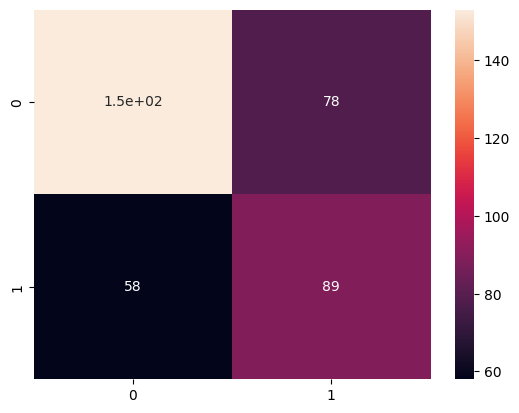

In [ ]:
# Convert probabilities to binary predictions (0 or 1)
y_pred = np.where(y_pred >= 0.5, 1, 0)
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, y_pred))

#Confusion Matrix - verify accuracy of each class
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
#print(cm)
sns.heatmap(cm, annot=True)

ResNet50 Feature extraction

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=resnet.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train = features

#Send test data through same feature extractor process
feature_extractor=resnet.predict(x_test)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_test = features

12/12 [==============================] - 2s 205ms/step


Hyperparameter tuning for XGBoost

In [ ]:
np.shape(X_train)

(1318, 131072)

In [ ]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.2, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

XGBoost Model training

In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
#XGBOOST
# Train the XGBoost model with best hyperparameters
#model = random_search.best_estimator_
model = xgb.XGBClassifier(scale_pos_weight=1, colsample_bytree = 0.4, subsample = 0.8, objective='binary:logistic',
                               n_estimators=1000, max_depth=4, tree_method='gpu_hist', eta = 0.1, gamma= 0.3)
model.fit(X_train, y_train, verbose = 10 )

#Now predict using the trained model.
y_pred = model.predict(X_test)

In [ ]:
# Convert probabilities to binary predictions (0 or 1)
y_pred = np.where(y_pred >= 0.5, 1, 0)

Accuracy =  0.7142857142857143


<Axes: >

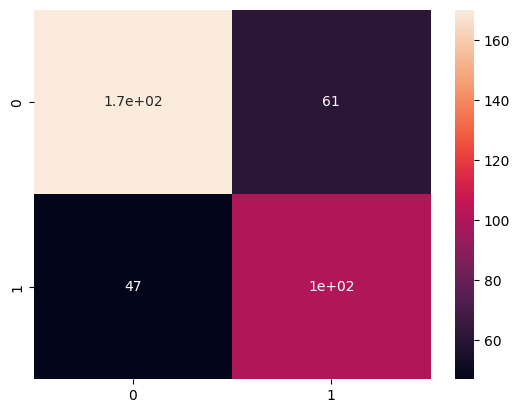

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, y_pred))

#Confusion Matrix - verify accuracy of each class
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
#Save model for future use
filename = 'XGBoostmodel.sav'
pickle.dump(model, open(filename, 'wb'))